# Prepare the data for the times series

In [1]:
import pandas as pd
uldf = pd.read_pickle('output/critical_15min_long_format.pickle')

# rename values of the condition for the plots
uldf['Condition'] = 'No-event day'
uldf.loc[uldf.mailed & uldf.mailday,'Condition'] = 'Event day - mailed'
uldf.loc[~uldf.mailed & uldf.mailday,'Condition'] = 'Event day - not mailed'

# rename values of the mailday for the plots
uldf['Mailday'] = 'Event day'
uldf.loc[~uldf.mailday,'Mailday'] = 'No-event day'

# rename values of the day type for the plots
uldf['Daytype'] = 'A. Weekday'
uldf.loc[~uldf.is_weekday, 'Daytype'] = 'B. Saturdays & Sundays'

# calculate watts
uldf['watts'] = uldf['charge'] * (1/4) * 1000

# this will create a dummy variable to properly sort the X-axes, interval_timedelta contains
# from 00:00 to 07:00 all the hours that are higher than 17:00
uldf['interval_timedelta'] = pd.to_timedelta(uldf['interval_time'].astype(str))
after17h = uldf['interval_timedelta'] >= pd.Timedelta(hours=17)
uldf.loc[after17h, 'interval_timedelta'] = uldf.loc[after17h, 'interval_timedelta'] - pd.Timedelta(hours=17)
uldf.loc[~after17h, 'interval_timedelta'] = uldf.loc[~after17h, 'interval_timedelta'] + pd.Timedelta(hours=7)

# extract the co2 rows
co2 = uldf.drop_duplicates(['interval', '17h_day', 'mailday', 'interval_time', 'kgCO2eq/kWh', 'Daytype']).copy()
co2= co2.sort_values([ 'interval_timedelta', 'Mailday', 'Daytype',])
co2['interval_time_str'] = co2['interval_time'].astype(str).str[:-3]

# commenting for the public version (avoid revealing non-agregated data)
# uldf.head()

# Plot: probability of a customer charging 

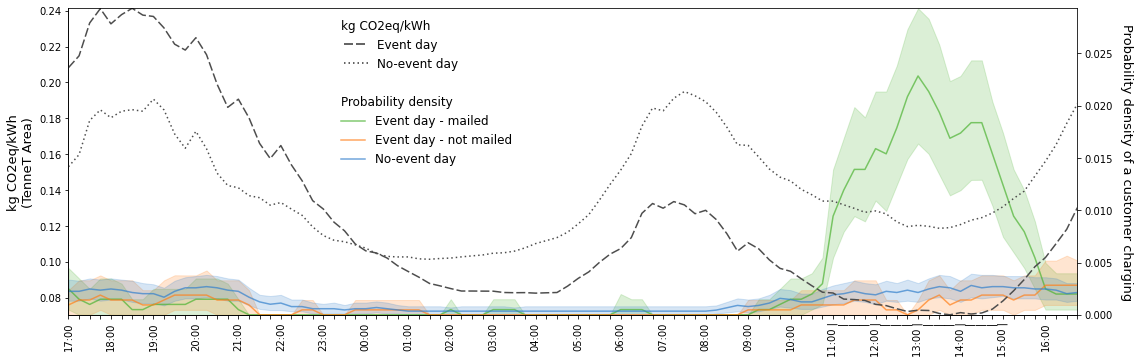

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette([
    (0.3, 0.7, 0.2), # green
    (1.0, 0.5, 0.1), # orange
    (0.2, 0.5, 0.8) # blue
])

dfplot=uldf#.sample(10000)

dfplot= dfplot.sort_values([ 'interval_timedelta', 'Condition', 'Daytype',])
dfplot['interval_time_str'] = dfplot['interval_time'].astype(str).str[:-3]

g = sns.FacetGrid(dfplot, hue="Condition", 
                  hue_order=['Event day - mailed', 'Event day - not mailed','No-event day'],
                  row_order= ['A. Weekday', 'B. Saturdays & Sundays'],
                  height=5, aspect=3, legend_out=False)
g.map(sns.lineplot, "interval_time_str", "charging", sort=False, alpha=.7, ci=95) # ci=None, to accelerate things
g.add_legend()

plt.xticks(rotation=90)

sns.set_palette([(0.3, 0.3, 0.3), (0.45, 0.45, 0.45)])
for i, ax in enumerate(g.axes.flatten()):
    
    ax.set_xlabel('')
    ax.margins(x=0, y=0)
    ax.set_title(ax.get_title(), fontsize=14)
    if i==0:
        ax.legend(frameon=False, title="Probability density               ", bbox_to_anchor=(0, 0, 0.45, 0.75),
              fontsize='12', title_fontsize='12')
    
    plt.xticks(rotation=90)
    
    ax2 = ax.twinx()
    sns.lineplot(data=co2, x='interval_time_str', y='kgCO2eq/kWh', 
                 style="Mailday", ci=None, sort=False, ax=ax2, dashes=[(6,2), (1,2)])
    
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_ylabel('Probability density of a customer charging', fontsize=13, rotation=270, labelpad=20)
    
    ax2.set_ylabel('')
    ax2.set_xlabel('')
    ax2.yaxis.tick_left()
    ax2.yaxis.set_label_position("left")
    ax2.set_ylabel("kg CO2eq/kWh\n(TenneT Area)", fontsize=13)
    ax2.margins(x=0, y=0)
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(loc="upper right", bbox_to_anchor=(0, 0, 0.4, 1),
              title="kg CO2eq/kWh        ", handles=handles2[1:], labels=labels2[1:], frameon=False,
              fontsize='12', title_fontsize='12')
    #ax.legend().texts[0].set_text("Whatever else")
    
    
#ax2.get_legend().remove()
#ax.get_legend().remove()


# handles1, labels1 = g.get_legend_handles_labels()
# handles = handles1 + handles2
# labels = labels1 + labels2
# g.legend( handles=handles[1:], labels=labels[1:])
    
criticals = set(f'{x}' for x in range(11,15)) 
ticks=[(
    (x if i%4==0 else '     ') +
    (' |' if x[:2] in criticals or x == '15:00'else '') 
) for i,x in enumerate(dfplot['interval_time_str'].unique())]
g.set_xticklabels(ticks)

g.set_titles(row_template="{row_name}", size=14)

